In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import kendalltau
from scipy.spatial.distance import pdist, squareform

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from math import sqrt
import matplotlib.pyplot as plt
from pyEDM import *

import warnings
warnings.filterwarnings('ignore')

### 一、Input 資料

1.1.載入資料

In [2]:
data = pd.read_csv('/Users/yitsung/git/MastersThesis/data/TaiwanStockData_Top100_EMA')
ticker_2330 = data[data['ticker']==2330].reset_index(drop=True)
ticker_2330 = ticker_2330.drop(columns=['ticker'])
ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.2.切Library和Prediction

In [3]:
Library = ticker_2330[ticker_2330['Date'] < '2023-06-30']
Prediction = ticker_2330[(ticker_2330['Date'] >= '2023-06-30')&(ticker_2330['Date'] <= '2023-11-29')] # 到用11/29預測11/30就好
Prediction.head()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
602,2023-06-30,570.0,576.0,568.0,576.0,33831.0,117.0,-2573.0,38737.0,649.0,-1545.0,6.1965,576.126478,575.383895,565.777341,9.606554,12.496515,34.306232
603,2023-07-03,578.0,580.0,576.0,579.0,15118.0,97.0,2353.0,-305.0,1401.0,582.0,2.5477,576.701182,575.940219,566.756798,9.183421,11.833896,33.311646
604,2023-07-04,585.0,585.0,580.0,585.0,17777.0,84.0,4805.0,-1348.0,-13.0,1767.0,2.7068,578.360946,577.334031,568.108146,9.225886,11.312294,30.627646
605,2023-07-05,589.0,589.0,579.0,582.0,15554.0,-50.0,-890.0,-503.0,-1092.0,-790.0,2.6473,579.088757,578.051873,569.137172,8.914701,10.832775,17.707207
606,2023-07-06,573.0,574.0,565.0,565.0,32070.0,563.0,-16476.0,-574.0,-603.0,-14045.0,5.1447,576.271005,576.043892,568.830715,7.213177,10.108856,7.697299


1.3.標準化(Minmax)

In [4]:
def make_data_minmax(Library, Prediction):

    feature_to_standardize = Library.columns.to_list()
    feature_to_standardize.remove(Library.columns[0])  # 排除Date
    feature_to_standardize.remove(Library.columns[4])  # 排除close

    # 處理target以外的feature
    scaler_X = MinMaxScaler() 
    Library[feature_to_standardize] = scaler_X.fit_transform(Library[feature_to_standardize])
    Prediction[feature_to_standardize] = scaler_X.fit_transform(Prediction[feature_to_standardize])

    # 處理target feature
    scaler_y = MinMaxScaler() 
    Library['close'] = scaler_y.fit_transform(Library['close'].values.reshape(-1, 1))
    Prediction['close'] = scaler_y.fit_transform(Prediction['close'].values.reshape(-1, 1))

    return Library, Prediction, scaler_y


In [5]:
Library, Prediction, scaler_y = make_data_minmax(Library=Library, Prediction=Prediction)

1.4.整併預測DataFrame

In [6]:
def concate_pred_data(Library, Prediction, th): # th=-1就是Library

    if th < 0:
        Lib_Pred_df = Library
    
    else:
        row_to_add = Prediction.iloc[th]
        Lib_Pred_df = pd.concat([Library, row_to_add.to_frame().T], ignore_index=True)
        
    # 這種concate方法會有非數值問題, 要這樣修正
    Lib_Pred_df[['open', 'high', 'low', 'close', 'volume', 'financing', 'fi', 'ii', 'di', 'rp', 'capital', 'EMA9', 'EMA12', 'EMA26', 'MACD', 'Signal', 'RSI14']] = Lib_Pred_df[['open', 'high', 'low', 'close', 'volume', 'financing', 'fi', 'ii', 'di', 'rp', 'capital', 'EMA9', 'EMA12', 'EMA26', 'MACD', 'Signal', 'RSI14']].apply(pd.to_numeric, errors='coerce')
    Lib_Pred_df['Date'] = pd.to_datetime(Lib_Pred_df['Date'])

    return Lib_Pred_df


In [7]:
# Lib_Pred_df = concate_pred_data(Library=Library, Prediction=Prediction, th=0)
# Lib_Pred_df.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
598,2023-06-26,0.653418,0.644013,0.662338,0.650641,0.156368,0.541869,0.425802,0.229975,0.321104,0.445355,0.202976,0.707717,0.709761,0.673675,0.650284,0.744644,0.508022
599,2023-06-27,0.634340,0.634304,0.646104,0.644231,0.103541,0.505087,0.428126,0.198268,0.332064,0.468425,0.138160,0.702469,0.707008,0.676538,0.624890,0.733508,0.453906
600,2023-06-28,0.662957,0.647249,0.652597,0.650641,0.076768,0.498513,0.430917,0.228551,0.324855,0.459063,0.127218,0.699748,0.705846,0.679815,0.605314,0.720099,0.410194
601,2023-06-29,0.659777,0.650485,0.649351,0.647436,0.072220,0.520582,0.444985,0.228107,0.385161,0.466145,0.115186,0.696833,0.704279,0.682536,0.586186,0.704976,0.348880
602,2023-06-30,0.736111,0.779412,0.732394,0.791667,0.467544,0.609867,0.407662,1.000000,0.609983,0.465376,0.565818,0.899545,0.902715,0.769223,0.925248,1.000000,0.343062


### 二、MDRSmap演算法 (前期)

2.1. 製作可餵入EDM格式的train_feature

In [8]:
def find_train_target_feature(data, target):

    df_columns = list(data.columns)
    train_feature = df_columns.copy()
    train_feature.remove('Date') # 先拿掉日期
    
    formatted_columns = ' '.join(df_columns[1:]) # 變成可以餵給 EDM function 參數 'columns' 的形式 
    train_feature.remove(target) # 再拿掉 target_feature

    return formatted_columns, train_feature

In [9]:
# formatted_columns, train_feature = find_train_target_feature(data=Library, target='close')
# formatted_columns

'open high low close volume financing fi ii di rp capital EMA9 EMA12 EMA26 MACD Signal RSI14'

2.2. 找出target_feature最佳嵌入維度

In [10]:
def find_target_OED(data, target):

    target_OED = EmbedDimension(dataFrame=data, lib=f'1 {len(data)}', pred=f'{len(data)-21} {len(data)-1}', columns=target, showPlot=False) # 4. lib訓練全部, pred看最後20筆

    target_OED_rho = target_OED['rho'].max()
    target_OED = int(target_OED['E'][target_OED['rho'] == target_OED['rho'].max()].iloc[0])

    return target_OED, target_OED_rho


In [11]:
# target_OED, target_OED_rho = find_target_OED(data=Library, target='close')
# print(f'target_OED: {target_OED}, target_OED_rho: {target_OED_rho}')

target_OED: 9, target_OED_rho: 0.7839198854338782


2.3. 找出所有有因果關係的train_feature

In [12]:
def find_rho_sig_df(data, ticker, target, target_OED, train_feature, E_max):
    
    crirho = stats.t.ppf(0.95, len(data) - 1) / (len(data) - 2 + stats.t.ppf(0.95, len(data) - 1) ** 2)
    ccm_libSizes = f'{target_OED+10} {len(data)-10} 10'
    # ccm_libSizes = list(range(10, len(data) + 1, 10)) + [len(data)]  # sequence of library size # original

    rho_sig_df = pd.DataFrame(columns=train_feature)
    for train in train_feature:

        ### 找出該train_feature最好的ccm_OED ###
        ccm_E_termRHO = pd.DataFrame(columns=['E', 'term_rho'])
        """
        這裡假設用 term_rho 來選 ccm_OED
        """
        for e in range(1, E_max+1):
            ccm_result = CCM(dataFrame=data, E=e, columns=train, target=target,
                            libSizes=ccm_libSizes, random=False, showPlot=False)
            # print(e, ccm_result[f'{target}:open'].iloc[-1]) # 有時候會有warning, 測試用
            new_data = {'E': e, 'term_rho': ccm_result[f'{target}:{train}'].iloc[-1]}
            ccm_E_termRHO.loc[len(ccm_E_termRHO)] = new_data

        max_term_rho_index = ccm_E_termRHO['term_rho'].idxmax()
        ccm_OED = ccm_E_termRHO.at[max_term_rho_index, 'E']

        ### 用最好的ccm_OED來做該feature的因果檢定 ###
        ccm_result = CCM(dataFrame=data, E=ccm_OED, columns=train, target=target, 
                        libSizes=ccm_libSizes, random=False, showPlot=False)
        """
        這裡假設用 target:train 、 LibSize 來做 kendalltau 檢定
        """
        ccm_result = ccm_result[['LibSize', f'{target}:{train}']]
        ccm_result[f'{target}:{train}'][ccm_result[f'{target}:{train}'] < 0] = 0
        term_rho = ccm_result[f'{target}:{train}'].iloc[-1]

        tau, p_value = kendalltau(ccm_result['LibSize'], ccm_result[f'{target}:{train}']) # 進行 kendalltau 相關檢定

        alpha = 0.05
        if (p_value < alpha) and (term_rho > crirho): # 顯著相關
            rho_sig_df[train] = [term_rho]

        else: # "不" 顯著相關
            rho_sig_df[train] = [0]

    rho_sig_df.index = pd.Index([f'{ticker}_{target}']) 
    
    return rho_sig_df


In [13]:
# rho_sig_df = find_rho_sig_df(data=Library, ticker=2330, target='close', target_OED=target_OED, train_feature=train_feature, E_max=10)
# rho_sig_df

,open,high,low,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
2330_close,0.995751,0.997907,0.997422,0.64106,0.322162,0.621344,0.132492,0.355262,0.650314,0.698587,0.998877,0.99812,0.985912,0.741278,0.670315,0.773993


2.4. 用有因果關係的train_feature建立Embed_df

In [14]:
def make_Embed_df(data, max_lag, target, rho_sig_df):

    #用有因果關係的 train feature + target feature 製作 Embed_df #
    non_zero_columns = rho_sig_df.loc[:, (rho_sig_df != 0).any(axis = 0)] # 選取值非0的column
    train_feature_ls = list(non_zero_columns.columns)
    formatted_columns = ' '.join(train_feature_ls) # 轉成 EDM column 的 input
    columns_to_lag = formatted_columns + f' {target}' # 加入 target 本身

    Embed_df = Embed(dataFrame=data, E=max_lag, tau=-1, columns=columns_to_lag) # 製作 Embed_df
    Embed_df['Date'] = data['Date'] # 加入Date來看index, 才可以防simplex func的bug
    Embed_df.dropna(inplace=True) # 把包含NaN的資料拿掉
    Embed_df = Embed_df.reset_index(drop=True)
    Embed_df = Embed_df[['Date'] + [col for col in Embed_df.columns if col != 'Date']]

    ML_df_date = Embed_df.copy()
    ML_df_date['Date'] = pd.to_datetime(ML_df_date['Date']) # 將index設為日期
    ML_df_date.set_index('Date', inplace=True)
    ML_df_date = ML_df_date.filter(like="(t-0)") # 只留下(t-0)的column

    return Embed_df, ML_df_date

In [15]:
# Embed_df, ML_df_date = make_Embed_df(data=Lib_Pred_df, max_lag=10, target='close', rho_sig_df=rho_sig_df)
# Embed_df.tail()

,Date,open(t-0),open(t-1),open(t-2),open(t-3),open(t-4),open(t-5),open(t-6),open(t-7),open(t-8),...,close(t-0),close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7),close(t-8),close(t-9)
589,2023-06-26,0.653418,0.672496,0.662957,0.675676,0.697933,0.697933,0.697933,0.707472,0.647059,...,0.650641,0.673077,0.679487,0.679487,0.698718,0.705128,0.701923,0.711538,0.650641,0.621795
590,2023-06-27,0.634340,0.653418,0.672496,0.662957,0.675676,0.697933,0.697933,0.697933,0.707472,...,0.644231,0.650641,0.673077,0.679487,0.679487,0.698718,0.705128,0.701923,0.711538,0.650641
591,2023-06-28,0.662957,0.634340,0.653418,0.672496,0.662957,0.675676,0.697933,0.697933,0.697933,...,0.650641,0.644231,0.650641,0.673077,0.679487,0.679487,0.698718,0.705128,0.701923,0.711538
592,2023-06-29,0.659777,0.662957,0.634340,0.653418,0.672496,0.662957,0.675676,0.697933,0.697933,...,0.647436,0.650641,0.644231,0.650641,0.673077,0.679487,0.679487,0.698718,0.705128,0.701923
593,2023-06-30,0.736111,0.659777,0.662957,0.634340,0.653418,0.672496,0.662957,0.675676,0.697933,...,0.791667,0.647436,0.650641,0.644231,0.650641,0.673077,0.679487,0.679487,0.698718,0.705128


In [16]:
# ML_df_date.tail()

,open(t-0),high(t-0),low(t-0),volume(t-0),financing(t-0),fi(t-0),ii(t-0),di(t-0),rp(t-0),capital(t-0),EMA9(t-0),EMA12(t-0),EMA26(t-0),MACD(t-0),Signal(t-0),RSI14(t-0),close(t-0)
Date,,,,,,,,,,,,,,,,,
2023-06-26,0.653418,0.644013,0.662338,0.156368,0.541869,0.425802,0.229975,0.321104,0.445355,0.202976,0.707717,0.709761,0.673675,0.650284,0.744644,0.508022,0.650641
2023-06-27,0.634340,0.634304,0.646104,0.103541,0.505087,0.428126,0.198268,0.332064,0.468425,0.138160,0.702469,0.707008,0.676538,0.624890,0.733508,0.453906,0.644231
2023-06-28,0.662957,0.647249,0.652597,0.076768,0.498513,0.430917,0.228551,0.324855,0.459063,0.127218,0.699748,0.705846,0.679815,0.605314,0.720099,0.410194,0.650641
2023-06-29,0.659777,0.650485,0.649351,0.072220,0.520582,0.444985,0.228107,0.385161,0.466145,0.115186,0.696833,0.704279,0.682536,0.586186,0.704976,0.348880,0.647436
2023-06-30,0.736111,0.779412,0.732394,0.467544,0.609867,0.407662,1.000000,0.609983,0.465376,0.565818,0.899545,0.902715,0.769223,0.925248,1.000000,0.343062,0.791667


2.5. 用simplex randomsearch找出最佳的view

In [17]:
def make_random_simplex(Embed_df, target, target_OED, kmax, kn):    

    Embed_for_train = Embed_df.drop(columns='Date') # 先把 Date 拿掉
    Embed_for_train = Embed_for_train.drop(columns=f'{target}(t-0)') # 先把 target 拿掉
    train_f_ls = list(Embed_for_train.columns) # train_feature
    train_f_num = len(Embed_for_train.columns) # train_feature 的個數

    rho_feature_view = pd.DataFrame(columns=['rho']) # 創建一個df去紀錄每個隨機view的資料
    new_column = pd.DataFrame(columns=['feature_' + str(i) for i in range(1, target_OED+1)])
    rho_feature_view = pd.concat([rho_feature_view, new_column], axis=1)
    k = 1
    while k <= kmax:
        random_pick_train = np.random.choice(train_f_num, target_OED, replace=False)
        # print(random_pick_train)

        train_f_ls = np.array(train_f_ls) # 變成 array 才可以一次選
        select_train_f = train_f_ls[random_pick_train] # 隨機選到的 train_feature
        formatted_random_columns = ' '.join(select_train_f) # 用成符合 EDM 的資料格式
        # print(formatted_random_columns)

        simp = Simplex(dataFrame=Embed_df, E=target_OED, # ver3: 測試近10 or 20個交易日
                       lib=f'1 {len(Embed_df)}', pred = f'{len(Embed_df)-21} {len(Embed_df)-1}', 
                       columns=formatted_random_columns, target=f'{target}(t-0)',
                       embedded = True, showPlot = False) # 原本是False現在改True
        # print(simp)

        sub_simp = simp[['Observations', 'Predictions']] # 計算rho
        rho = sub_simp['Observations'].corr(sub_simp['Predictions'])

        rho_feature_view.loc[len(rho_feature_view), 'rho'] = rho # 將 view 更新到 rho_feature_view 的 df 中
        rho_feature_view.loc[len(rho_feature_view)-1, rho_feature_view.columns[1:]] = select_train_f
        # print(rho)
        k += 1

    allscore = rho_feature_view.sort_values(by='rho', ascending=False).head(kn)
    allscore = allscore.reset_index(drop=True)

    return allscore

In [18]:
# allscore = make_random_simplex(Embed_df=Embed_df, target='close', target_OED=target_OED, kmax=10000, kn=5)
# allscore.head()

,rho,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,0.812306,di(t-7),fi(t-2),financing(t-6),EMA9(t-0),ii(t-7),di(t-8),RSI14(t-6),capital(t-6),capital(t-1)
1,0.80124,capital(t-9),di(t-4),rp(t-9),EMA12(t-2),EMA26(t-5),fi(t-6),RSI14(t-0),fi(t-8),Signal(t-0)
2,0.794621,EMA9(t-2),open(t-8),EMA12(t-8),RSI14(t-1),rp(t-8),financing(t-2),fi(t-3),open(t-0),fi(t-9)
3,0.785317,fi(t-7),RSI14(t-6),close(t-2),Signal(t-9),RSI14(t-2),RSI14(t-0),MACD(t-0),EMA26(t-6),capital(t-6)
4,0.784595,ii(t-9),RSI14(t-0),high(t-0),open(t-5),close(t-7),close(t-9),volume(t-8),rp(t-9),EMA9(t-2)


### 三、MDRSmap演算法 (後期)

3.1. 計算每個時點的(view加權)距離

In [19]:
def compute_view_w_distance(Embed_df, allscore):

    ww = allscore['rho'] / allscore['rho'].sum() # 每個view的權重

    dmatrix_ls = []
    for j in range(allscore.shape[0]):

        view_feature = allscore.iloc[j, 1:] # 選取第j個view的所有feature
        view_feature = np.array(view_feature) # 把所有feature變成array才可以從完整Embed_df中找資料
        view_feature_value = Embed_df[view_feature]
        view_matrix = view_feature_value.to_numpy() # 從df形式變array
        view_matrix = np.vstack(view_matrix) # 這樣才能疊成matrix

        Dx_t2 = pdist(view_matrix, metric='euclidean') * ww[j] # 計算加權距離
        Dx_t2 = squareform(Dx_t2) # 將距離變成squareform
        dmatrix_ls.append(Dx_t2)

    v_w_dmatrix = np.sum(dmatrix_ls, axis=0) # 輸出每個時點的view加權距離

    return v_w_dmatrix

In [20]:
# v_w_dmatrix = compute_view_w_distance(Embed_df=Embed_df, allscore=allscore)
# v_w_dmatrix

array([[0.        , 0.25240166, 0.27883279, ..., 0.70660403, 0.76145397,
        0.79032449],
       [0.25240166, 0.        , 0.21184102, ..., 0.69773771, 0.73427449,
        0.76393939],
       [0.27883279, 0.21184102, 0.        , ..., 0.65381802, 0.70755271,
        0.72761898],
       ...,
       [0.70660403, 0.69773771, 0.65381802, ..., 0.        , 0.2318788 ,
        0.32916402],
       [0.76145397, 0.73427449, 0.70755271, ..., 0.2318788 , 0.        ,
        0.22716536],
       [0.79032449, 0.76393939, 0.72761898, ..., 0.32916402, 0.22716536,
        0.        ]])

3.2.尋找elastic-net最佳參數

In [21]:
def find_MDRSmap_param(target, ML_df_date, theta_seq, v_w_dmatrix):

    result_ls = pd.DataFrame(columns=['Theta', 'Score', 'Param']) # 創建紀錄回測結果的dataframe

    ### 將原始資料乘上空間位置權數 ###
    tp = len(ML_df_date) -1
    tp_distence = v_w_dmatrix[tp] # 第tp個時點離其他時點的距離
    mask = np.ones(len(tp_distence), dtype=bool) # 遮蔽該時點計算平均數
    mask[tp] = False
    dpar = np.mean(tp_distence[mask]) # 第tp個時點離其他時點的平均數

    for theta in theta_seq:
        w_tp = np.exp(-theta * tp_distence / dpar) # 計算每個時點資料的加權
        w_tp = np.sqrt(w_tp)

        ### 加入答案列 ###
        ML_df_date_new = ML_df_date.copy()
        ML_df_date_new[f'ans(t-0)'] = ML_df_date_new[f'{target}(t-0)'].shift(-1) # step.1: 先將target往前移n, 製作y
        ML_df_date_new = ML_df_date_new.multiply(w_tp, axis=0) # step.2: 再將data乘上距離加權
        ML_df_date_new = ML_df_date_new[:-2] # step.3: 拿掉最後n+1個, 因為最後面的data是硬拼上去的
        # ML_df_date_new = ML_df_date_new.drop(columns=[f'{target}(t-0)']) # step.4: 原paper有刪target啦, 這邊可選擇刪或不刪
        # ML_df_date_new = ML_df_date_new.dropna().reset_index(drop=True) # 不確定要不要用

        ### 分拆train, validation(以近60天為基準) ###
        X = ML_df_date_new.iloc[:, :-1]
        y = ML_df_date_new.iloc[:, -1]
        val_fold = [-1] * (len(X)-60) + [0] * 60 # 最後60筆當validation set
        ps = PredefinedSplit(test_fold=val_fold)

        elastic_net = ElasticNet(precompute=True,
                                 fit_intercept=True,
                                 warm_start=True,
                                 random_state=87)

        ### grid search ###
        param_grid = {'alpha': [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
                      'l1_ratio': [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
                      'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
                      
        grid_search = GridSearchCV(estimator=elastic_net, 
                                   param_grid=param_grid, 
                                   cv=ps, scoring='neg_mean_squared_error', 
                                   return_train_score=True)
                                   # neg_mean_squared_error # neg_mean_absolute_error

        grid_search.fit(X, y)

        ### 記錄結果 ###
        result_ls.loc[len(result_ls), 'Theta'] = theta
        result_ls.loc[len(result_ls)-1, 'Score'] = grid_search.best_score_
        result_ls.loc[len(result_ls)-1, 'Param'] = [grid_search.best_params_]

        theta = result_ls['Theta'][result_ls['Score'].idxmax()]
        param = result_ls['Param'][result_ls['Score'].idxmax()][0]

    return result_ls, theta, param

In [22]:
# result_ls, theta, param = find_MDRSmap_param(target='close', 
#                                              ML_df_date=ML_df_date, 
#                                              theta_seq=[1,2,4,7,11,16,22], 
#                                              v_w_dmatrix=v_w_dmatrix)

3.3.用最佳參數訓練MDRSmap

In [23]:
def MDRSmap_model(target, ML_df_date, theta, v_w_dmatrix, param):

    ### 將原始資料乘上空間位置權數 ###
    tp = len(ML_df_date) -1
    tp_distence = v_w_dmatrix[tp] # 第tp個時點離其他時點的距離
    mask = np.ones(len(tp_distence), dtype=bool) # 遮蔽該時點計算平均數
    mask[tp] = False
    dpar = np.mean(tp_distence[mask]) # 第tp個時點離其他時點的平均數

    w_tp = np.exp(-theta * tp_distence / dpar) # 計算每個時點資料的加權
    w_tp = np.sqrt(w_tp)

    ### 加入答案列 ###
    ML_df_date_new = ML_df_date.copy()
    ML_df_date_new[f'ans(t-0)'] = ML_df_date_new[f'{target}(t-0)'].shift(-1) # step.1: 先將target往前移n, 製作y
    ML_df_date_new = ML_df_date_new.multiply(w_tp, axis=0) # step.2: 再將data乘上距離加權
    ML_df_date_new = ML_df_date_new[:-2] # step.3: 拿掉最後n+1個, 因為最後面的data是硬拼上去的
    # ML_df_date_new = ML_df_date_new.drop(columns=[f'{target}(t-0)']) # step.4: 原paper有刪target啦, 這邊可選擇刪或不刪
    # ML_df_date_new = ML_df_date_new.dropna().reset_index(drop=True) # 不確定要不要用

    ### 分拆train, validation(以近60天為基準) ###
    X = ML_df_date_new.iloc[:, :-1]
    y = ML_df_date_new.iloc[:, -1]

    elastic_net = ElasticNet(precompute=True,
                             fit_intercept=True,
                             warm_start=True,
                             random_state=87,
                             **param)

    elastic_net.fit(X, y)

    return elastic_net

In [24]:
# elastic_net = MDRSmap_model(target='close', ML_df_date=ML_df_date, 
#                             theta=theta, v_w_dmatrix=v_w_dmatrix, param=param)

3.4.進行預測

In [25]:
# X_pred = np.array(ML_df_date.iloc[-1]).reshape(1, -1)
# y_pred = elastic_net.predict(X_pred)
# y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))[0][0]
# y_pred

575.3492598941782

3.5.製作評估dataframe

In [26]:
# Date = ticker_2330['Date'][(ticker_2330['Date']>='2023-07-01')&(ticker_2330['Date']<='2023-11-30')].reset_index(drop=True)
# Today = ticker_2330['close'][(ticker_2330['Date']>='2023-07-01')&(ticker_2330['Date']<='2023-11-30')].reset_index(drop=True)
# Yesterday = ticker_2330['close'][(ticker_2330['Date']>='2023-06-30')&(ticker_2330['Date']<='2023-11-29')].reset_index(drop=True)

# MDRSmap_result = pd.DataFrame(Date)
# MDRSmap_result['Observations'] = Today
# MDRSmap_result['Predictions'] = None
# MDRSmap_result['Yesterday'] = Yesterday
# MDRSmap_result

### 四、完整預測流程

4.1.完整預測流程

In [29]:
### 一、Input資料(到1.3.前略) ###
### 從 6/30 預測 7/03 開始 ###

### 製作評估dataframe ###
Date = ticker_2330['Date'][(ticker_2330['Date']>='2023-07-01')&(ticker_2330['Date']<='2023-11-30')].reset_index(drop=True)
Today = ticker_2330['close'][(ticker_2330['Date']>='2023-07-01')&(ticker_2330['Date']<='2023-11-30')].reset_index(drop=True)
Yesterday = ticker_2330['close'][(ticker_2330['Date']>='2023-06-30')&(ticker_2330['Date']<='2023-11-29')].reset_index(drop=True)

MDRSmap_result = pd.DataFrame(Date)
MDRSmap_result['Observations'] = Today
MDRSmap_result['Predictions'] = None
MDRSmap_result['Yesterday'] = Yesterday

### 開始進行MDRSmap演算法 ###
for th in range(0, len(Prediction)):

    if th == 0: ### th = 0, 要找view ###
        Lib_Pred_df = concate_pred_data(Library=Library, Prediction=Prediction, th=th)
        formatted_columns, train_feature = find_train_target_feature(data=Lib_Pred_df, target='close')
        target_OED, target_OED_rho = find_target_OED(data=Lib_Pred_df, target='close')
        rho_sig_df = find_rho_sig_df(data=Lib_Pred_df, ticker=2330, target='close', 
                                     target_OED=target_OED, train_feature=train_feature, E_max=10)
        Embed_df, ML_df_date = make_Embed_df(data=Lib_Pred_df, max_lag=10, target='close', rho_sig_df=rho_sig_df)
        allscore = make_random_simplex(Embed_df=Embed_df, target='close', target_OED=target_OED, kmax=10000, kn=5)
        v_w_dmatrix = compute_view_w_distance(Embed_df=Embed_df, allscore=allscore)
        result_ls, theta, param = find_MDRSmap_param(target='close', 
                                                     ML_df_date=ML_df_date, 
                                                     theta_seq=[1,2,4,7,11,16,22], 
                                                     v_w_dmatrix=v_w_dmatrix)
        elastic_net = MDRSmap_model(target='close', ML_df_date=ML_df_date, 
                                    theta=theta, v_w_dmatrix=v_w_dmatrix, param=param)
        
        ### 預測 ###
        X_pred = np.array(ML_df_date.iloc[-1]).reshape(1, -1)
        y_pred = elastic_net.predict(X_pred)
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))[0][0]

        ### 將結果併入評估dataframe ###
        MDRSmap_result.loc[th, 'Predictions'] = y_pred
        print(f"{MDRSmap_result['Date'][th]}: finished")
    
    else: ### th > 0, 僅算距離+預測 ###
        Lib_Pred_df = concate_pred_data(Library=Library, Prediction=Prediction, th=th)
        Embed_df, ML_df_date = make_Embed_df(data=Lib_Pred_df, max_lag=10, target='close', rho_sig_df=rho_sig_df)
        v_w_dmatrix = compute_view_w_distance(Embed_df=Embed_df, allscore=allscore)
        result_ls, theta, param = find_MDRSmap_param(target='close', 
                                                     ML_df_date=ML_df_date, 
                                                     theta_seq=[1,2,4,7,11,16,22], 
                                                     v_w_dmatrix=v_w_dmatrix)
        elastic_net = MDRSmap_model(target='close', ML_df_date=ML_df_date, 
                                    theta=theta, v_w_dmatrix=v_w_dmatrix, param=param)
        
        ### 預測 ###
        X_pred = np.array(ML_df_date.iloc[-1]).reshape(1, -1)
        y_pred = elastic_net.predict(X_pred)
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1))[0][0]

        ### 將結果併入評估dataframe ###
        MDRSmap_result.loc[th, 'Predictions'] = y_pred
        print(f"{MDRSmap_result['Date'][th]}: finished")

0: 575.1909176949254
1: 577.3449564752902
2: 579.5411815266067
3: 578.7036426436835
4: 571.1357028542693
5: 570.5621349648212
6: 569.788500992743
7: 572.9728453871636
8: 572.8479133114906
9: 578.8265883626557
10: 581.297715282075
11: 581.5046722856013
12: 579.091446964029
13: 579.0753250886461
14: 578.398993378403
15: 568.1040700426029
16: 567.6627296695724
17: 569.5241103048805
18: 568.1922011407984
19: 569.0003292081459
20: 567.9266700945177
21: 567.1676273553022
22: 566.278290793828
23: 563.4566977159636
24: 559.3132686122616
25: 560.0094535503451
26: 557.0038978858535
27: 556.3835652964459
28: 554.4335252249167
29: 551.9958641663402
30: 547.0621430015584
31: 547.3267994900017
32: 544.886249084503
33: 545.1827652531242
34: 543.1285251721392
35: 541.5348697956553
36: 542.2181913349741
37: 546.3442524539164
38: 552.2434017672559
39: 545.9433224645481
40: 547.6445341469848
41: 548.1034255642573
42: 551.7110634691288
43: 549.9355511325803
44: 548.5551350398811
45: 552.1040081341945
46: 

4.2.繪圖

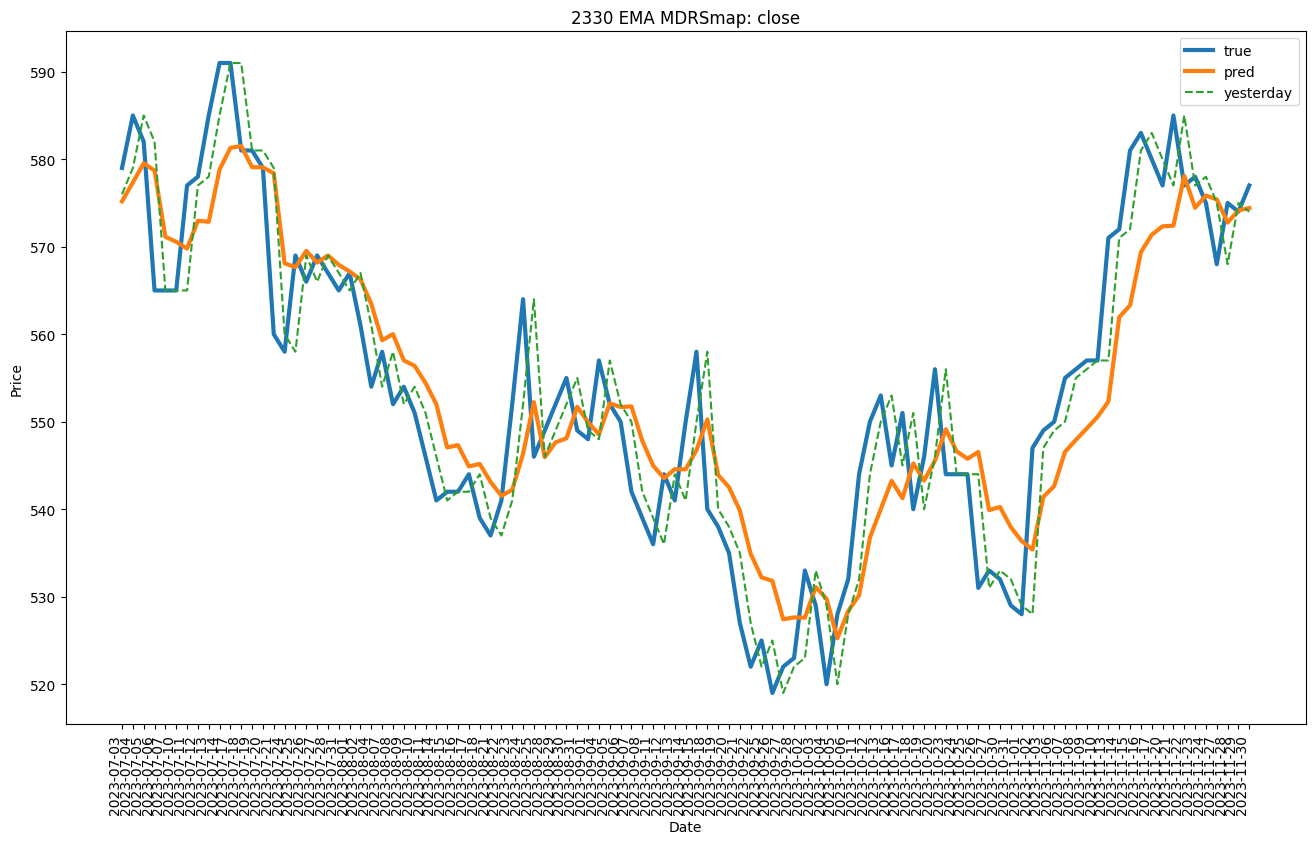

In [34]:
plt.figure(figsize=(16, 9))
plt.plot(MDRSmap_result['Date'], MDRSmap_result[f'Observations'], linewidth=3, label='true')
plt.plot(MDRSmap_result['Date'], MDRSmap_result[f'Predictions'], linewidth=3, label='pred')
plt.plot(MDRSmap_result['Date'], MDRSmap_result[f'Yesterday'], linestyle='--', label='yesterday')

plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Price')
plt.title(f'2330 EMA MDRSmap: close')
plt.legend()
plt.show()